## Summary of the notebook

**train configuration**: <br> 
eager execution = disabled <br> 

if eager execution is not disabled following error occurs: <br>
TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), 
dtype=tf.float32, name=None), name='Placeholder:0', description="created 
by layer 'tf.cast_4'"), an intermediate Keras symbolic input/output, 
to a TF API that does not allow registering custom dispatchers, 
such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. 
Keras Functional model construction only supports TF API calls that 
*do* support dispatching, such as `tf.math.add` or `tf.reshape`. 
Other APIs cannot be called directly on symbolic Kerasinputs/outputs. 
You can work around this limitation by putting the operation in a custom 
keras layer `call` and calling that layer on this symbolic input/output. 

**process**:
1. Define the model and fit the model by using the train, validation and test data 
2. Save the trained model at the specified path
3. Use the trained model and pass it to the StochasticRegressor class
4. From the object returned in 3., access predict_output(). This function returns the samples, pred_mean and pred_std  
5. Plot the prediction mean and +- 1 std dev against the ground truth to visualize the performance of the model

**critical points and checklist** 
1. the script should yield a trained model  
2. pdfs ad pngs in the output plots folder 
3. check model training configuration once

**analysis**
1. for num_samples = 20 and a single input record (of shape (1,8)): <br> 
intermediate samples shape : (20, 1, 1) <br> 
final mean and std/var shape : (1, 1)

## Mount the drive

In [1]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting the correct path

In [2]:
import os

project_path = '/content/drive/MyDrive/MasterThesis'
task_name = 'CaliforniaHousingDatasetTests'
exp_name = 'GBP_explanation'
uncert_name = 'dropconnect'

%cd /content/drive/MyDrive/MasterThesis/ 

print(os.getcwd())
path = project_path + '/' + task_name + '/' + exp_name + '/' + uncert_name + '/' # 'CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
explanation_path = os.path.join(path, 'explanation_files')
explanation_heatmap_path = os.path.join(path, 'explanation_heatmaps')
print(path)
print(explanation_path)
print(explanation_heatmap_path)

/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/explanation_files
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/explanation_heatmaps


## Removing previous trained models

In [3]:
#list_of_files = os.listdir(path)
#print(path) 

#for item in list_of_files:
#    if item.endswith('.h5'):
#        print(f'deleting {item}')
#        os.remove(os.path.join(path, item))

## Imports

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

import os
import random 
import math

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

#tf.compat.v1.disable_eager_execution()
print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,'/content/drive/My Drive/MasterThesis/src/')

from utils import *

2.8.0
Eager execution enabled : True


## Load data

In [5]:
train_data, train_labels, val_data, val_labels, test_data, test_labels, feature_names = load_california_housing_data()

#print these values to test the load function 
#print(train_labels[20])
#print(val_labels[30])
#print(test_labels[40])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)


## Class definitions

### StochasticModel & StochasticRegressor

In [6]:
import numpy as np
import keras
import keras.backend as K

Layer = keras.layers.Layer
Dropout = keras.layers.Dropout


class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10, **kwargs):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)
#            samples[i] = self.model(x, training=True)

        if multi_output:
            return samples
        else:
            return np.array(samples)
            
            
class  StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=1, **kwargs):
        # https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers
        super().__init__(model, num_samples)
        self.input = self.model.input
        self.output = self.model.output


    def __call__(self, inp, num_samples=2, batch_size=32, output_scaler=None, **kwargs):
        print('the call function is called ')
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)
        print('__call__ samples ', samples)
        print('__call__ mean_pred ', mean_pred)
        print('__call__ std_pred ', std_pred)

        return samples, mean_pred, std_pred 


    def predict_output(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)
        print('Intermediate samples shape ', samples.shape)   # should be (#samples, #input records, 1 )

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)
        print('mean_pred \n', mean_pred)
        print('std_pred \n', std_pred)

        return samples, mean_pred, std_pred 

    def save(self, path):
        # stochaticmodel class does not have basic tf function like save(), summary(), get_layer() and so on 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        self.model.save(path)

    def summary(self):
        return self.model.summary()  

    def evaluate(self, test_data):
        return self.model.evaluate(test_data)

    def get_layer(self, name=None, index=None):
        # the get_layer() has been taken from ths following source 
        # https://github.com/keras-team/keras/blob/v2.8.0/keras/engine/training.py#L2797-L2831
    
        """Retrieves a layer based on either its name (unique) or index.
        If `name` and `index` are both provided, `index` will take precedence.
        Indices are based on order of horizontal graph traversal (bottom-up).
        Args:
            name: String, name of layer.
            index: Integer, index of layer.
        Returns:
            A layer instance.
        """
        # TODO(fchollet): We could build a dictionary based on layer names
        # since they are constant, but we have not done that yet.
        if index is not None and name is not None:
            raise ValueError('Provide only a layer name or a layer index. Received: '
                        f'index={index}, name={name}.')

        if index is not None:
            if len(self.layers) <= index:
                raise ValueError(f'Was asked to retrieve layer at index {index}'
                            f' but model only has {len(self.layers)}'
                            ' layers.')
            else:
                return self.model.layers[index]

        if name is not None:
            for layer in self.model.layers:
                if layer.name == name:
                    return layer
            raise ValueError(f'No such layer: {name}. Existing layers are: '
                        f'{list(layer.name for layer in self.model.layers)}.')
        raise ValueError('Provide either a layer name or layer index at '
                     '`get_layer`.')

### Dropconnect Layer

In [7]:
import keras.backend as K

Dense = keras.layers.Dense
Conv1D = keras.layers.Conv1D
Conv2D = keras.layers.Conv2D
Conv3D = keras.layers.Conv3D

class DropConnect:
    def __init__(self, prob=0.5, drop_bias=False, noise_shape=None):
        self.prob = prob
        self.drop_bias = drop_bias
        self.noise_shape = noise_shape
        self.kernel_noise_shape = None
        self.bias_noise_shape = None

    @property
    def needs_drop(self):
        return 0.0 < self.prob < 1.0

    def sample(self, tensor, dropit=True, noise_shape=None):
        if dropit:
            return K.dropout(tensor, self.prob, noise_shape)

        return tensor

    def replace_tensor(self, tensor_train, tensor_test):
        if self.uses_learning_phase:
            return K.in_train_phase(tensor_train, tensor_test)
        else:
            return tensor_train

    def get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape

        symbolic_shape = K.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape
                       for axis, shape in enumerate(self.noise_shape)]

        return tuple(noise_shape)

    def get_config(self):
        config = {
            "prob": self.prob,
            "drop_bias": self.drop_bias,
            "noise_shape": self.noise_shape
        }

        return config

class DropConnectDense(DropConnect, Dense):
    def __init__(self, units, prob=0.5, drop_bias=False, noise_shape=None, use_learning_phase = False, **kwargs):
        DropConnect.__init__(self, prob=prob, drop_bias=drop_bias, noise_shape=noise_shape)
        Dense.__init__(self, units, **kwargs)

        if self.needs_drop:
            self.uses_learning_phase = use_learning_phase

    def call(self, inputs, **kwargs):
        kernel_sample = self.sample(self.kernel)
        bias_sample = self.sample(self.bias, dropit=self.drop_bias)

        outputs = K.dot(inputs, kernel_sample)
        
        if self.use_bias:
            outputs += bias_sample

        # This always produces stochastic outputs
        return self.activation(outputs)

    def get_config(self):
        config_dc = DropConnect.get_config(self)
        config_base = Dense.get_config(self)

        return dict(list(config_dc.items()) + list(config_base.items()))

## Define and train Dropconnect model

THIS IS THE TRAINING PHASE
Epoch 1/250
4/4 - 2s - loss: 0.1860 - mae: 0.3588 - val_loss: 0.1734 - val_mae: 0.3357 - lr: 0.0010 - 2s/epoch - 463ms/step
Epoch 2/250
4/4 - 0s - loss: 0.1677 - mae: 0.3321 - val_loss: 0.1587 - val_mae: 0.3130 - lr: 0.0010 - 87ms/epoch - 22ms/step
Epoch 3/250
4/4 - 0s - loss: 0.1599 - mae: 0.3203 - val_loss: 0.1466 - val_mae: 0.2936 - lr: 0.0010 - 77ms/epoch - 19ms/step
Epoch 4/250
4/4 - 0s - loss: 0.1385 - mae: 0.2876 - val_loss: 0.1352 - val_mae: 0.2756 - lr: 0.0010 - 49ms/epoch - 12ms/step
Epoch 5/250
4/4 - 0s - loss: 0.1296 - mae: 0.2736 - val_loss: 0.1260 - val_mae: 0.2617 - lr: 0.0010 - 111ms/epoch - 28ms/step
Epoch 6/250
4/4 - 0s - loss: 0.1157 - mae: 0.2532 - val_loss: 0.1194 - val_mae: 0.2513 - lr: 0.0010 - 110ms/epoch - 27ms/step
Epoch 7/250
4/4 - 0s - loss: 0.1062 - mae: 0.2388 - val_loss: 0.1136 - val_mae: 0.2439 - lr: 0.0010 - 94ms/epoch - 24ms/step
Epoch 8/250
4/4 - 0s - loss: 0.0974 - mae: 0.2273 - val_loss: 0.1090 - val_mae: 0.2388 - lr: 0.00

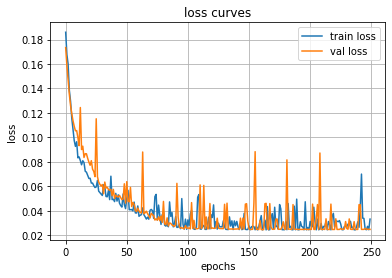

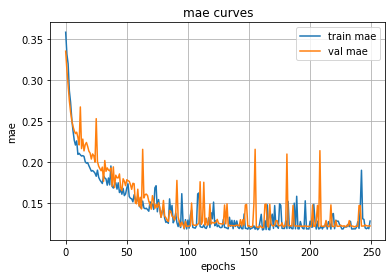

THIS IS THE INFERENCE PHASE
Intermediate samples shape  (10, 3000, 1)
mean_pred 
 [[0.64494145]
 [0.3926144 ]
 [0.6089783 ]
 ...
 [0.18349175]
 [0.2950163 ]
 [0.8853307 ]]
std_pred 
 [[0.0664551 ]
 [0.064489  ]
 [0.        ]
 ...
 [0.01503223]
 [0.02553435]
 [0.07702142]]
pred_samples shape 
 (10, 3000, 1)
pred_mean shape 
 (3000, 1)
pred_std shape 
 (3000, 1)
prediction mean :
 [[0.64494145]
 [0.3926144 ]
 [0.6089783 ]
 ...
 [0.18349175]
 [0.2950163 ]
 [0.8853307 ]]
prediction mean shape  (3000, 1)
prediction std :
 [[0.0664551 ]
 [0.064489  ]
 [0.        ]
 ...
 [0.01503223]
 [0.02553435]
 [0.07702142]]
prediction std shape  (3000, 1)
prediction samples :
 [[[0.6776999 ]
  [0.27900428]
  [0.6089783 ]
  ...
  [0.19009417]
  [0.3035277 ]
  [0.9110044 ]]

 [[0.48902705]
  [0.43391773]
  [0.6089783 ]
  ...
  [0.14101976]
  [0.3035277 ]
  [0.9110044 ]]

 [[0.6776999 ]
  [0.43391773]
  [0.6089783 ]
  ...
  [0.17314413]
  [0.3035277 ]
  [0.9110044 ]]

 ...

 [[0.6776999 ]
  [0.43391773]
  [

In [12]:
# DROPCONNECT MODEL
def train_model(x_train, y_train, x_val, y_val, x_test, epochs, num_samples, prob, noise_shape, train_batch_size, validation_batch_size, test_batch_size,  train_flag=None):
    #obtained from hyperparameter optimization
    K.clear_session()

    model = Sequential()
    model.add(Input(shape=(8, )))


    #model.add(Dense(32, activation='relu'))
    #model.add(Dense(16, activation='relu'))
    #model.add(Dense(8, activation='relu'))
    #model.add(DropConnectDense(4, activation='relu', prob=prob, noise_shape=noise_shape))
    #model.add(Dense(1, activation='relu'))

    #THE FOLLOWING MODEL WORKS REASONABLY WELL  
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='relu'))
    
    model.add(DropConnectDense(1, activation='relu', prob=prob, noise_shape=noise_shape))

    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    # adam yields increasing validation loss and mae

    def adapt_learning_rate(epoch):
        if epoch<100:
            return 1e-3
        elif epoch>=100 and epoch<175:
            return 1e-4 
        else:
            return 1e-5

    lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)

    # train a model with dropconnect() layer
    print('THIS IS THE TRAINING PHASE')
    history = model.fit(x_train, 
                        y_train, 
                        batch_size=train_batch_size,
                        validation_data=(x_val, y_val), 
                        callbacks=[lr_scheduler],
                        #validation_batch_size=validation_batch_size,
                        verbose=2, 
                        epochs=epochs)
    
    #saving the model that has custom layers
    print(os.path.join(path, 'saved_models', 'model_epochs_'+str(epochs)+'_num_samples_'+str(num_samples)+'.h5'))
    model.save(os.path.join(path, 'saved_models', 'model_epochs_'+str(epochs)+'_num_samples_'+str(num_samples)+'.h5') )
    model.summary()

    # plotting the training and validation curves 
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('loss curves')
    plt.show()

    plt.plot(history.history['mae'], label='train mae')
    plt.plot(history.history['val_mae'], label='val mae')
    plt.legend()
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('mae')
    plt.title('mae curves')
    plt.show()

    # call the stochasticregressor class and pass the trained model that contains the dropconnect layer 
    mc_model = StochasticRegressor(model)
    print('THIS IS THE INFERENCE PHASE')
    pred_samples, pred_mean, pred_std = mc_model.predict_output(x_test, 
                                                                batch_size=test_batch_size,
                                                                num_samples=num_samples)
    print('pred_samples shape \n', pred_samples.shape)
    
    
    print('pred_mean shape \n', pred_mean.shape)
    print('pred_std shape \n', pred_std.shape)

    # return the predicted_samples, predicted_mean, predicted_std and model 
    return pred_samples, pred_mean, pred_std, mc_model

epochs=250
num_samples=10
prob=0.1
noise_shape=None
train_batch_size=4096
validation_batch_size=4096
test_batch_size=4096 
# running this command creates the stochastic dropconnect model, trains it and generates the predicted_samples, predicted_mean and predicted_std for the test set (all 3000 examples)
prediction_samples, prediction_mean, prediction_std, stochastic_model = train_model(train_data, 
                                                                                    train_labels, 
                                                                                    val_data, 
                                                                                    val_labels, 
                                                                                    test_data, 
                                                                                    epochs=epochs, 
                                                                                    num_samples=num_samples, 
                                                                                    prob=prob, 
                                                                                    noise_shape=noise_shape,
                                                                                    train_batch_size=train_batch_size, 
                                                                                    validation_batch_size=validation_batch_size, 
                                                                                    test_batch_size=test_batch_size)
print('prediction mean :\n', prediction_mean)
print('prediction mean shape ', prediction_mean.shape)
print('prediction std :\n', prediction_std)
print('prediction std shape ', prediction_std.shape)
print('prediction samples :\n', prediction_samples)
print('prediction samples shape ', prediction_samples.shape)
print('unique standard deviation values \n', np.unique(prediction_std))

## Ground Truth vs prediction plot

In [11]:
# Analysis of the input 
#num_of_inputs_to_be_explained = 1
#start_index = np.random.randint(0, test_data.shape[0])
#print('start_index : ', start_index)

#test_input = test_data[start_index:start_index+num_of_inputs_to_be_explained]
#print('test_input shape :', test_input.shape)

#test_input_adj = np.expand_dims(test_input, axis=-1)
#print('test_input_adj shape :', test_input_adj.shape)

pred_samples, pred_mean, pred_std = stochastic_model.predict_output(test_data, num_samples=num_samples)
print('pred samples shape ', pred_samples.shape)
print('pred mean shape ', pred_mean.shape)
print('pred std shape ', pred_std.shape)

print('pred samples : \n ', pred_samples)
print('pred mean : \n ', pred_mean)
print('pred std : \n ', pred_std)
print('max pred std ', np.max(pred_std))
print('min pred std ', np.min(pred_std))

Intermediate samples shape  (10, 3000, 1)
mean_pred 
 [[0.6320692 ]
 [0.40624553]
 [0.53816426]
 ...
 [0.20123772]
 [0.28526908]
 [0.8076879 ]]
std_pred 
 [[5.96046448e-08]
 [8.59823227e-02]
 [1.15634605e-01]
 ...
 [1.92460306e-02]
 [7.86093026e-02]
 [0.00000000e+00]]
pred samples shape  (10, 3000, 1)
pred mean shape  (3000, 1)
pred std shape  (3000, 1)
pred samples : 
  [[[0.63206923]
  [0.43453333]
  [0.57659966]
  ...
  [0.1916147 ]
  [0.3159317 ]
  [0.8076879 ]]

 [[0.63206923]
  [0.43453333]
  [0.57659966]
  ...
  [0.1916147 ]
  [0.3159317 ]
  [0.8076879 ]]

 [[0.63206923]
  [0.43453333]
  [0.57659966]
  ...
  [0.1916147 ]
  [0.3159317 ]
  [0.8076879 ]]

 ...

 [[0.63206923]
  [0.43453333]
  [0.57709205]
  ...
  [0.1916147 ]
  [0.3159317 ]
  [0.8076879 ]]

 [[0.63206923]
  [0.43787277]
  [0.57659966]
  ...
  [0.1916147 ]
  [0.37420142]
  [0.8076879 ]]

 [[0.63206923]
  [0.43453333]
  [0.19126092]
  ...
  [0.23972978]
  [0.13018283]
  [0.8076879 ]]]
pred mean : 
  [[0.6320692 ]
 [0

[1.21028148e-01 5.22866100e-02 0.00000000e+00 2.70538945e-02
 6.82973191e-02 4.97935824e-02 4.95147221e-02 2.58507729e-02
 2.04202998e-02 5.66578284e-02 2.22898126e-02 4.24726382e-02
 7.45770112e-02 5.75133935e-02 2.61155963e-02 4.27855290e-02
 3.84861231e-02 4.71662693e-02 7.24788532e-02 6.76878691e-02
 5.96046448e-08 4.75489832e-02 6.93200305e-02 4.62755337e-02
 2.02252939e-02 5.96046448e-08 2.50902176e-02 0.00000000e+00
 2.98023224e-08 4.88757789e-02 2.98023224e-08 2.42539998e-02
 5.99524528e-02 7.33314380e-02 0.00000000e+00 2.38384008e-02
 5.55224195e-02 9.39404070e-02 0.00000000e+00 2.30205860e-02
 6.29509017e-02 9.77541059e-02 1.24596268e-01 1.48045598e-02
 2.23346893e-02 6.97715878e-02 5.96046448e-08 7.77008310e-02
 3.34327258e-02 6.13048337e-02 2.07619071e-02 4.06223312e-02
 4.86323573e-02 4.85535525e-02 5.53437397e-02 8.44621584e-02
 4.56724651e-02 2.58488599e-02 5.96046448e-08 2.85514593e-02
 8.72876421e-02 6.50872365e-02 4.64959405e-02 2.02117767e-02
 2.70701647e-02 2.014176

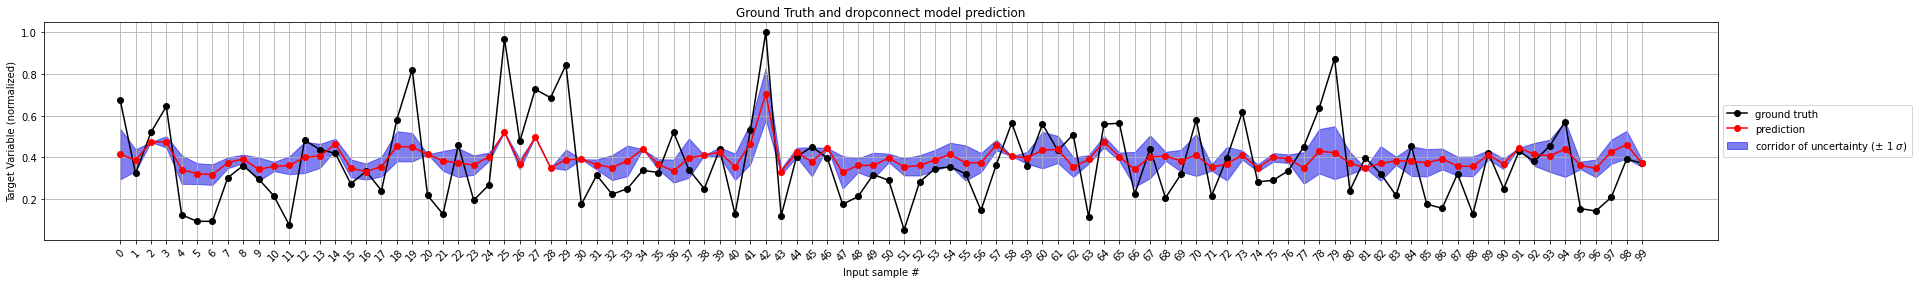

In [ ]:
start_index = np.random.randint(test_data.shape[0]-150)
#random = range(start_index, start_index+100)
#print('indices to be plotted \n', random)
#random = range(start_index, start_index+100) # to test the model prediction on random chunk of inputs 
random = range(0, 100)  # to test the model predictions on first 100 inputs 
test_labels_plot = np.asarray([float(test_labels[i]) for i in random])
mean_flipout_plot = np.asarray([float(pred_mean[i]) for i in random])
std_flipout_plot = np.asarray([float(pred_std[i]) for i in random])

print(std_flipout_plot)

plot_gt_vs_pred(test_labels_plot, mean_flipout_plot, std_flipout_plot, path+'output_plots/'+uncert_name+'_gt_vs_prediction', random, uncert_name)

## GBP Logic

In [ ]:
# tf1 implementation for GBP 

import numpy as np

import keras
from keras import backend as K

import tensorflow as tf
from tensorflow.python.framework import ops

#Code partially based on https://github.com/eclique/keras-gradcam/blob/master/grad_cam.py

def make_guided_bp_model(model_fn):
    """
        Transform model to have overriden ReLU gradient for guided backpropagation.
        Parameters
        ----------
        model_fn: callable
            Function that builds and returns a model instance    
    """

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = K.get_session().graph
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        gbp_model = model_fn

    return gbp_model

def guided_bp(input_image, label, gbp_model, layer_name, output_idx=-1):
    """
        Performs guided backpropagation saliency computation.
        Parameters
        ----------
        input_image: numpy array
            Image to compute saliency
        gbp_model: keras.models.Model
            Keras model with overriden gradient, see make_guided_bp_model
        layer_name: str
            Name of the layer to compute gradients
        output_idx: int
            Index of the output neuron to compute gradients, defaults to use whole output vector
    """

    inp = gbp_model.input
    
    outp = gbp_model.get_layer(layer_name).output
    
    
    if output_idx > 0:
        outp = outp[:, output_idx]

    gradient = K.gradients(outp, inp)[0]
    grad_fn = K.function([inp, K.learning_phase()], [gradient])
    grads_val = grad_fn([input_image, 0])[0]


    output_fn = K.function([inp], [outp])
    output = output_fn([input_image])

    #print('output ', output)
    #print('type output ', type(output))

    #print('prediction \n', output)
    #print('prediction shape ', output[0].shape)
    print('GT ', label)
    print('Prediction ', output[0][0])
    return grads_val, output[0][0]

## Create GBP model

In [ ]:
gbp_model = make_guided_bp_model(stochastic_model)
gbp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 54        
                                                                 
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
 dense_2 (Dense)             (None, 6)                 42        
                                                                 
 drop_connect_dense (DropCon  (None, 1)                1         
 nectDense)                                                      
                                                                 
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________


## Generate GBP explanations

In [ ]:
number_of_explanations_per_input = 3
number_of_inputs_to_be_explained = 2
count = 0 

list_of_input_to_be_explained = [] 
list_of_input_gt = [] 

list_of_gbp_explanation = [] 
list_of_gbp_prediction = [] 

import time 

start = time.time()
for input, label in zip(test_data, test_labels):
    input = np.expand_dims(input, axis=0)
    
    if count<number_of_inputs_to_be_explained:
        count+=1 
        print(f'Processing Input # {count}')
        
        list_of_explanation_for_single_input = [] 
        list_of_prediction_for_single_input = [] 

        for i in range(number_of_explanations_per_input):
            print(f'Generating explanation # {i} for Input # {count}')
            gbp_explanation = guided_bp(input, label, gbp_model, 'drop_connect_dense')
            
            #print(f'gbp explanation {gbp_explanation}')

            list_of_explanation_for_single_input.append(gbp_explanation)
            
            print('-------------------------------------------')  

        
        list_of_gbp_explanation.append(list_of_explanation_for_single_input)
        #list_of_gbp_prediction.append(list_of_prediction_for_single_input)
        list_of_input_to_be_explained.append(input)
        list_of_input_gt.append(label) 


        print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
        print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')  

    else:
        break 

print(list_of_gbp_explanation)
end = time.time()

Processing Input # 1
Generating explanation # 0 for Input # 1
GT  [0.67476298]
Prediction  [0.4930545]
-------------------------------------------
Generating explanation # 1 for Input # 1
GT  [0.67476298]
Prediction  [0.4930545]
-------------------------------------------
Generating explanation # 2 for Input # 1
GT  [0.67476298]
Prediction  [0.4930545]
-------------------------------------------
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Processing Input # 2
Generating explanation # 0 for Input # 2
GT  [0.32251241]
Prediction  [0.40971878]
-------------------------------------------
Generating explanation # 1 for Input # 2
GT  [0.32251241]
Prediction  [0.40971878]
-------------------------------------------
Generating explanation # 2 for Input # 2
GT  [0.32251241]
Prediction  [0.40971878]
-------------------------------------------
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
[[(array([[ 0.05036059,

## Save inputs to be explained 

In [ ]:
print('time elapsed to generate explanations (seconds) ', end-start) 

#saving the input to be explained as np array 
np.save(os.path.join(explanation_path, f'GBP_list_of_input_to_be_explained.npy'),
        list_of_input_to_be_explained,
        allow_pickle=True)

#save the corresponding ground truth
np.save(os.path.join(explanation_path, f'GBP_list_of_input_gt.npy'),
        list_of_input_gt,
        allow_pickle=True)

time elapsed to generate explanations (seconds)  0.2743723392486572


## Save GBP explanations

In [ ]:
#save the explanations 
np.save(os.path.join(explanation_path, f'list_of_gbp_explanation.npy'),
        list_of_gbp_explanation,
        allow_pickle=True)

#save the model prediction 
np.save(os.path.join(explanation_path, f'list_of_gbp_prediction.npy'),
        list_of_gbp_prediction,
        allow_pickle=True)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Plot explanation code

In [ ]:
# code for horizontal bar chart 

def plot_explanation(grads_plot, feature_names, sample_number=None, err=None, save_file_path=None, combination_title=None):
    plt.figure(figsize=(15, 10))
    #plt.barh(pos, vals, color=colors) #this code works well but does not have legend or text in int

    print('grads_plot ', list(grads_plot))
    colors = ['C1' if x > 0 else 'C0' for x in list(grads_plot)] # originally negative=red and positive=green (coloring scheme)
    colors_set = set(colors)
    #print('colors_set before ', colors_set)
    colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]
    #print('colors_set after ', colors_set)
    exp = list(grads_plot)
    pos = np.arange(len(exp)) + .5
    #print('pos values for plot are ', pos)

    vals = [float(x) for x in exp]
    vals_str = [str(round(val, 3)) for val in vals]
    #print('vals_str ', vals_str)

    #colors = ['r', 'g', 'b']
    labels = colors_set 
    legend_colors = list(set(colors))
    #print(legend_colors)
    handles = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
    #print(handles)

    vals = [np.abs(num) if num  == 0 else num for num in vals] # removing the sign from 0 vals
    #print('vals ', vals)

    #max_horizontal_value_to_plot_text_box = np.max(vals)

    for i, v in enumerate(vals):
        if err is None:
            # in case the text box needs to be moved along the bar then switch 0 to v
            plt.text(v, i+0.5, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

        elif err is not None:
            # in case of the combined explanation, the text box should contain the mean+-std as well
            plt.text(v, i+0.7, str(round(v, 3))+'$\pm$'+str(round(err[i], 3)), Bbox = dict(facecolor = 'grey', alpha =0.2))

    axx = plt.barh([i for i in pos], vals, xerr=err, align='center', color=colors) # this code appropriate legend

    plt.grid(alpha=0.5)
    plt.ylabel('feature names')
    plt.xlabel('feature coefficient')
    plt.yticks(pos, feature_names[:-1])

    if err is not None:
        error = plt.plot([], label='corridor of uncertainty ($\pm \sigma$)', linewidth=3, linestyle='-', color='k')
        plt.title(f'combined explanation , prediction : {combination_title[0]} $\pm$ {combination_title[1]} , GT : {combination_title[2]}')
        main_bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        #first_legend = plt.legend(handles=error)
        #second_legend = plt.legend(handles=main_bar)

        handles = error + main_bars #https://stackoverflow.com/questions/28732845/combine-two-pyplot-patches-for-legend       
        error_label = ['corridor of uncertainty ($\pm \sigma$)']
        main_bars_label = colors_set

        labels = error_label + main_bars_label
        plt.legend(handles, labels)

    else:
        handles=[plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        plt.title(f'explanation for sample_number {sample_number}')
        plt.legend(handles, labels) # https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column

    plt.subplots_adjust()
    plt.savefig(save_file_path+'.pdf')
    plt.savefig(save_file_path+'.png')

## Test the quality of generated GBP explanation (sample few inputs and view the explanations)

In [ ]:
inputs = np.load(os.path.join(explanation_path, f'GBP_list_of_input_to_be_explained.npy'))
print('inputs shape ', inputs.shape)

gt_labels = np.load(os.path.join(explanation_path, f'GBP_list_of_input_gt.npy'))
print('gt labels shape ', gt_labels.shape)


gbp_explanations = np.load(os.path.join(explanation_path, f'list_of_gbp_explanation.npy'))
print('gbp explanation shape ', gbp_explanation.shape)

list_of_gbp_outputs = np.load(os.path.join(explanation_path, f'list_of_gbp_prediction.npy'))
print('list of gbp outputs shape ', list_of_gbp_outputs.shape)

for input in range(gbp_explanations.shape[0]):
    for explanation in range(gbp_explanations[input].shape[0]):
        print(input, explanation)
        print(gbp_explanations[input][explanation].shape)
        print(gbp_explanations[input][explanation])
        #plot_explanation(gbp_explanations[i].squeeze(axis=0), feature_names, i)
        print('xxxxxx')


inputs shape  (2, 1, 8)
gt labels shape  (2, 1)


ValueError: ignored

## TESTING SECTION [SANDBOX]

In [ ]:
# code to understand how the dropconnect works 
# https://stackoverflow.com/questions/44355229/can-i-use-tf-nn-dropout-to-implement-dropconnect/44416128
#https://www.kaggle.com/hengzheng/no-dropout-vs-dropout-vs-dropconnect-on-cnn

'''
### imports
import tensorflow.compat.v1 as tf

### constant data
x  = [[0.,0.],[1.,1.],[1.,0.],[0.,1.]]
y_ = [[1.,0.],[1.,0.],[0.,1.],[0.,1.]]

print('x is ', x)
print('y_ is ', y_) 

### induction

# Layer 0 = the x2 inputs
x0 = tf.constant( x  , dtype=tf.float32 )
y0 = tf.constant( y_ , dtype=tf.float32 )

print('x0 is ', x0)
print('y0 is ', y0)

keep_prob = tf.placeholder( dtype=tf.float32 )

# Layer 1 = the 2x12 hidden sigmoid
m1 = tf.Variable( tf.random_uniform( [2,12] , minval=0.1 , maxval=0.9 , dtype=tf.float32  ))
b1 = tf.Variable( tf.random_uniform( [12]   , minval=0.1 , maxval=0.9 , dtype=tf.float32  ))

print('m1 is ', m1)
print('b1 is ', b1) 


########## DROP CONNECT
# - use this to preform "DropConnect" flavor of dropout
dropConnect = tf.nn.dropout( m1, keep_prob ) * keep_prob
h1 = tf.sigmoid( tf.matmul( x0, dropConnect ) + b1 ) 

########## DROP OUT
# - uncomment this to use "regular" dropout
#h1 = tf.nn.dropout( tf.sigmoid( tf.matmul( x0,m1 ) + b1 ) , keep_prob )


# Layer 2 = the 12x2 softmax output
m2 = tf.Variable( tf.random_uniform( [12,2] , minval=0.1 , maxval=0.9 , dtype=tf.float32  ))
b2 = tf.Variable( tf.random_uniform( [2]   , minval=0.1 , maxval=0.9 , dtype=tf.float32  ))
y_out = tf.nn.softmax( tf.matmul( h1,m2 ) + b2 )


# loss : sum of the squares of y0 - y_out
loss = tf.reduce_sum( tf.square( y0 - y_out ) )

# training step : discovered learning rate of 1e-2 through experimentation
train = tf.train.AdamOptimizer(1e-2).minimize(loss)

### training
# run 5000 times using all the X and Y
# print out the loss and any other interesting info
with tf.Session() as sess:
  sess.run( tf.initialize_all_variables() )
  print( "\nloss")
  for step in range(5000) :
    sess.run(train,feed_dict={keep_prob:0.5})
    if (step + 1) % 100 == 0 :
      print( sess.run(loss,feed_dict={keep_prob:1.}))


  results = sess.run([m1,b1,m2,b2,y_out,loss],feed_dict={keep_prob:1.})
  labels  = "m1,b1,m2,b2,y_out,loss".split(",")
  for label,result in zip(*(labels,results)) :
    print ("")
    print (label)
    print (result)

print ("")
'''